<div hidden>
$\DeclareMathOperator{tr}{tr}$
$\DeclareMathOperator{sign}{sign}$
$\DeclareMathOperator{\argmin}{argmin}$
</div>

# Decomposição aditiva de matrizes

Considere novamente problemas de estimação cujo parâmetro tem a estrutura de matriz. Modelamos anteriormente o caso em que o parâmetro tem posto pequeno. Existem aplicações em que vale a pena modelar o parâmetro da forma

$$
B^* = \Gamma^* + S^*,  
$$

onde $\Gamma^*$ é uma matriz de posto $r$ e $S^*$ é uma matriz com no máximo $s$ entradas não-nulas. são matrizes $\mathbb{R}^{d_1\times d_2}$. Neste projeto iremos implementar métodos iterativos para achar a solução do seguinte estimador de mínimos quadrados regularizado:

\begin{equation*}
\begin{aligned}
& \underset{[\Gamma,S]\in(\mathbb{R}^{d_1\times d_2})^2}{\text{minimize}}
& & f(\Gamma,S) + \lambda\Vert \Gamma\Vert_N + \tau\Vert S\Vert_1, \\
& \text{sujeito à}
& & \Vert\Gamma\Vert_\infty\le a, 
\end{aligned}
\end{equation*}
onde 

$$
f(\Gamma, S) := \frac{1}{2n}\sum_{i=1}^n\left\{
y_i-tr\left(
X_i^\top(\Gamma + S)
\right)
\right\}^2, 
$$

$(y_1,X_1), \ldots, (y_n,X_n)$ é uma amostra de labels/features em $\mathbb{R}\times\mathbb{R}^{d_1\times d_2}$. Àcima, $\lambda,\tau,a>0$ são hyper-parâmetros,  

$$
\Vert \Gamma\Vert_N := \sum_{j=1}^{\min\{d_1,d_2\}}\sigma(B),
$$

é a *norma nuclear* da matriz $\Gamma$, onde $\sigma_1(\Gamma)\ge\cdots\ge\sigma_{\min\{d_1,d_2\}}(\Gamma)$ são os valores singulares de $B$. Além disso,  

$$
\Vert \Gamma\Vert_\infty := \max_{(j,k)\in[d_1]\times[d_2]}|\Gamma_{jk}|,
$$

é a *norma $\ell_\infty$* da matriz $\Gamma$ e 

$$
\Vert S\Vert_1 := \sum_{j=1}^{d_1}\sum_{k=1}^{d_2}|S_{jk}|,
$$

é a *norma $\ell_1$* da matriz $S$.


Exemplos de aplicação de variações deste problema incluem [*multi-task learning*](https://medium.com/gumgum-tech/multi-task-learning-what-is-it-how-does-it-work-and-why-does-it-work-294769c457bb) e [*análise multiômica*](https://academic.oup.com/bioinformatics/article/37/16/2259/6154849?login=false).
  

# Soft-Thresholding matricial


Os métodos que veremos para os problemas anteriores se baseam na idéia de *splitting*. Por exemplo, note que o o problema de otimização em PCA robusta exige otimizar em duas variáveis $[\Gamma, S]$. Entretanto otimizar simultaneamente é mais difícil do que otimizar alternadamente. 

Precisaremos computar os operadores proximais das normas nuclear e $\ell_1$. O *operador proximal* da norma $\lambda\Vert\cdot\Vert_N$ com restrição $\Vert\Gamma\Vert_{\infty}\le a$ é 

\begin{equation*}
P_N(W,\lambda,a) = 
\begin{aligned}
& \underset{\Gamma \in \mathbb{R}^{d_1\times d_2}}{\text{armin}}
& & \frac{1}{2}\Vert W - \Gamma \Vert_F^2 + 
\lambda\Vert \Gamma\Vert_N, \\
& \text{sujeito à}
& & \Vert\Gamma\Vert_\infty\le a.
\end{aligned}
\end{equation*}

$P_N(W,\lambda,a)$ tem fórmula explicíta. Dados $\gamma\in\mathbb{R}$, defina

$$
S_a(\gamma,\lambda):=sign(\gamma)\cdot\min\left\{
\max\{\gamma-\lambda,0\}, a
\right\}.
$$

Àcima, $sign(\gamma)$ é o sinal de $\gamma$. Seja agora a decomposição de valores singulares (SVD) de $W$:
$$
W = U\cdot D(\gamma_1,\ldots,\gamma_r)\cdot V^\top.
$$
Então, 
$$
P_N(W,\lambda,a) = U\cdot D\left( S_a(\gamma_1,\lambda),\ldots, S_a(\gamma_r,\lambda)\right)\cdot V^\top, 
$$
chamado de matriz *constraint soft-thresholding* de $W$.

O *operador proximal* da norma $\tau\Vert\cdot\Vert_1$ é 

$$
P_1(W,\tau)\in\argmin_{S\in\mathbb{R}^{d_1\times d_2}}\left\{
\frac{1}{2}\Vert W - S\Vert_F^2 + \tau\Vert S\Vert_1
\right\}.
$$

$P_1(W,\tau)$ também tem fórmula explicíta. Dados $\gamma\in\mathbb{R}$, defina

$$
S(\gamma,\lambda):=sign(\gamma)\cdot\max\{\gamma-\lambda,0\}.
$$

$P_1(W,\tau)$ é a matriz $d_1\times d_2$ cuja $[j,k]$-ézima entrada é $S(W_{j,k},\tau)$. 

In [1]:
import matplotlib
import numpy as np
import scipy
from scipy.linalg import svd
from scipy.stats import ortho_group
import seaborn as sns
import matplotlib.pyplot as plt
import numpy.linalg as la
import math

# Exercício 1:

Construa as funções ``soft(x,l)`` que retorna $S(x,\lambda)$ e ``csoft(x,l,a)`` que retorna $S_a(x,\lambda)$. 

In [2]:
#Escreva o código aqui

def soft(x, l):
    return np.sign(x) * np.maximum(np.abs(x) - l, 0)

def csoft(x, l, a):
    return np.sign(x) * np.minimum(np.maximum(np.abs(x) - l, 0), a)

# Exercício 2: Gerando dados

Construa uma função ``data_genG(n,d1,d2,r,Gamma_mag)`` que toma $d_1$, $d_2$, posto $r$ e número positivo ``Gamma_mag`` e retorna a matriz $\Gamma^*$ de dimensão $d_1\times d_2$ e posto $r$ com $\Vert\Gamma\Vert_\infty$ no máximo $\Gamma_{mag}/\sqrt{n}$. Ao gerar esta matriz $\Gamma^*$, use a função ```scipy.stats.ortho_group``` para construir duas matrizes $U$ e $V$ aleatórias ortogonais de dimensões $d_1\times r$ e $d_2\times r$ respectivamente; compute $U\cdot D(\Gamma_{mag},\ldots,\Gamma_{mag})\cdot V^\top$ e finalmente, normalize esta matriz entrada por entrada para satisfazer $\Vert\Gamma^*\Vert\le\Gamma_{mag}/\sqrt{n}$.

In [3]:
#Escreva o código aqui
def data_genG(n:int, d1:int, d2:int, r:int, Gamma_mag):
    U = ortho_group.rvs(d1)[:, :r]
    V = ortho_group.rvs(d2)[:, :r]
    
    D = np.diag([Gamma_mag] * r)
    
    G = U @ D @ V.T
    
    max_abs_value = np.max(np.abs(G))
    scaling_factor = Gamma_mag / (np.sqrt(n) * max_abs_value)
    G *= scaling_factor
    
    return G

In [4]:
#Exemplo:
n=100
d_1=10
d_2=10
r=5
Gamma_mag=10
Gamma_true = data_genG(n,d_1,d_2,r,Gamma_mag)
Gamma_true.shape, np.max(abs(Gamma_true)), Gamma_true, 

((10, 10),
 1.0,
 array([[-0.49873816, -0.66880067, -0.00224845,  0.46740684, -0.05255644,
          0.36482271, -0.20987616,  0.00594542,  0.03196712,  0.6016911 ],
        [-0.21313235, -0.86640258,  0.26905729,  0.34961733, -0.03548951,
          0.74805417, -0.04003684, -0.06199331, -0.31612676, -0.37512195],
        [ 0.23826161, -0.05364853,  0.16167221, -0.01068157,  0.02245308,
          0.01068147,  0.30887507, -0.12145022, -0.03020603, -0.22531498],
        [ 0.27324669, -0.18482364,  0.07106079,  0.12495145,  0.53853577,
          0.42575613,  0.1733974 , -0.4781849 ,  0.21957311, -0.62000665],
        [ 0.05492353, -0.27915305,  0.064262  ,  0.10388329,  0.14892447,
          0.20233356,  0.06278295, -0.07365862, -0.02737908, -0.12937954],
        [-0.27664641,  0.31596884,  0.43752316, -0.05145322, -1.        ,
          0.18246125,  0.16872592, -0.11811275, -0.33584901, -0.55662749],
        [ 0.30056355,  0.10972496, -0.27818698, -0.3168599 ,  0.67933142,
          0.182

# Exercício 3: Gerando dados

Construa uma função ``data_genS(d1,d2,s,S_mag)`` que toma $d_1$, $d_2$, esparsidade $s\in[d_1d_2]$ e número positivo ``S_mag`` e retorna a matriz $d_1\times d_2$ com $s$ entradas iguais a $S_{mag}$ e outras entradas iguais a zero. Escolha as entradas não-nulas aleatoriamente.

In [5]:
#Escreva o código aqui
def data_genS(d1, d2, s, S_mag):
    S_2 = np.zeros((d1, d2))
    
    indices = np.random.choice(d1 * d2, size=s, replace=False)
    
    np.put(S_2, indices, S_mag)
    
    return S_2

In [6]:
#Exemplo:
d_1=12
d_2=5
s=10
S_mag=10
S_true = data_genS(d_1,d_2,s,S_mag)
S_true

array([[ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., 10.],
       [ 0.,  0.,  0.,  0., 10.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0., 10., 10.,  0.,  0.],
       [ 0.,  0., 10.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., 10.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0., 10.,  0.,  0.,  0.],
       [ 0.,  0., 10.,  0.,  0.],
       [ 0., 10.,  0.,  0., 10.]])

# Exercício 4:

Construa uma função ``data_genXe(n,d_1,d_2,Gamma_true,S_true,sd)`` que toma $n$, $d_1$, $d_2$, $\Gamma^*$, $S^*$ e um número positivo ``sd`` e constrói os dados ``X``, uma lista de $n$ matrizes $X_i$ de dimensão $d_1\times d_2$ independentes cujas entradas são iid normais padrão. A função também retorna o vetor ``y`` de dimensão $n$ cujas coordenadas satisfazem

$$
y_i = tr(X_i^\top (\Gamma^* + S^*)) + \text{sd}\cdot\epsilon_i,
$$
onde $\{\epsilon_i\}_{i=1}^n$ é uma sequência iid de normais padrão. 

In [7]:
#Escreva o código aqui
def data_genXe(n ,d1, d2, B_true, sd):
    X = [np.random.normal(0, 1, (d1, d2)) for _ in range(n)]
    y = np.zeros(n)
    
    for i in range(n):
        epsilon_i = np.random.normal(0, 1)
        y[i] = np.trace(X[i].T @ (B_true)) + sd * epsilon_i
    
    return X, y.reshape(-1, 1)

In [8]:
#Exemplo:
d_1=40
d_2=40
r=5
s=10
Gamma_mag=10
S_mag=10
sd = 1
n = 100

Gamma_true = data_genG(n,d_1,d_2,r,Gamma_mag)
S_true = data_genS(d_1,d_2,s,S_mag)
B_true = Gamma_true + S_true
X,y = data_genXe(n,d_1,d_2,B_true,sd)

In [9]:
type(X), len(X), X[0].shape

(list, 100, (40, 40))

In [10]:
type(y), len(y), y.shape

(numpy.ndarray, 100, (100, 1))

# Exercício 5:

Construa uma função `df(Gamma,S)` que retorna o gradiente $\nabla f(\Gamma, S)$.

In [11]:
#Escreva o código aqui
def df(Gamma, S, X, y):
    n = len(X)
    d1, d2 = Gamma.shape
    
    grad = np.zeros((d1, d2))
    
    for i in range(n):
        residual = y[i] - np.trace(X[i].T @ (Gamma + S))
        grad -=(residual / n) * X[i]
    
    return grad

In [12]:
df(Gamma_true,S_true, X, y).shape, df(Gamma_true,S_true, X, y)

((40, 40),
 array([[-0.13400293,  0.02874845,  0.02436298, ..., -0.04166667,
         -0.01536312, -0.027167  ],
        [ 0.13388242,  0.04282262, -0.01151025, ..., -0.13410362,
          0.11943379, -0.10996513],
        [ 0.11241919, -0.00493189,  0.03645951, ..., -0.18512454,
          0.19109448, -0.02590672],
        ...,
        [-0.09402541, -0.01361852, -0.15678534, ...,  0.01365337,
         -0.04023099,  0.20241397],
        [-0.02107659, -0.03469191,  0.01685514, ..., -0.03102825,
          0.29263083, -0.14045154],
        [-0.04224072,  0.03930978, -0.0031048 , ...,  0.07449242,
         -0.04156161,  0.00969423]]))

# Exercício 6: 

Vamos usar o método gradiente proximal com splitting para resolver o problema àcima:

\begin{align*}
W_{\Gamma,k+1} &:= \Gamma_k - \frac{1}{L}\nabla f(\Gamma_k,S_k),\\
W_{S,k+1} &:= S_k - \frac{1}{L}\nabla f(\Gamma_k,S_k),\\
\Gamma_{k+1} &:= P_N\left(W_{\Gamma, k+1},\frac{\lambda}{L},a\right), \\
S_{k+1} &:= P_1\left(W_{S, k+1},\frac{\tau}{L}\right).
\end{align*}

Construa uma função ``trace_reg_MD(Df, n,d_1,d_2,X,y,L,lambd,tau,a, Gamma0,S0,tfinal)`` onde `Df` é uma função que retorna o gradiente, $1/L$ é o passo, ``lambd`` ($=\lambda$) e ``tau`` ($=\tau$) são os fatores de penalização, ``Gamma0`` e ``S0`` são os pontos iniciais, e a variável ``tfinal`` é o número de iterações. A função deve retornar a sequência $k\mapsto\Vert\nabla f(\Gamma_k,S_k)\Vert_F^2$ e os últimos iterados $\Gamma_{\text{tfinal}}$ e $S_{\text{tfinal}}$. Use hyper-parâmetros:

\begin{align*}
a &= \frac{\Gamma_{mag}}{\sqrt{n}},\\
\lambda &= \text{sd}\sqrt{\frac{d_1+d_2}{n}},\\
\tau &= \text{sd}\sqrt{\frac{\log(d_1d_2)}{n}} + \frac{\Gamma_{mag}}{\sqrt{n}}.
\end{align*}

e passo $A/L$ ajustando $A\ge1$ com
$$
L = A \cdot \lambda_{\max}\left(
\frac{1}{n}\sum_{i=1}^n\text{vec}(X_i)\text{vec}^\top(X_i)
\right),
$$ 
onde $\text{vec}(X_i)$ representa a matrix $d_1\times d_2$ $X_i$ em forma vetorial de dimensão $d_1d_2$.

In [13]:
#Escreva o código aqui
def trace_reg_MD(Df, n, d1, d2, X, y, L, lambd, tau, a, Gamma0, S0, tfinal):
    Gamma, S = Gamma0, S0
    grad_norms = list()
    
    for t in range(tfinal):
        grad = Df(Gamma, S, X, y)
        
        W_Gamma = Gamma - (1 / L) * grad
        W_S = S - (1 / L) * grad
        
        U, D, Vt = svd(W_Gamma, full_matrices=False)
        D_thresholded = csoft(D, lambd, a)
        Gamma = U @ np.diag(D_thresholded) @ Vt
        S = soft(W_S, tau / L)
        
        grad_norm = np.linalg.norm(grad) ** 2
        grad_norms.append(grad_norm)
    
    return grad_norms, Gamma, S

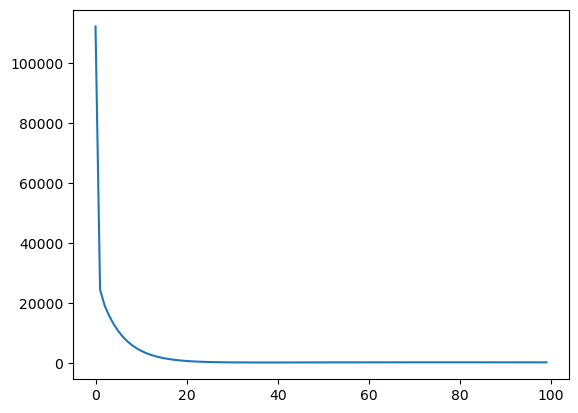

In [14]:
#Exemplo:
Gamma0 = np.ones((d_1,d_2))
S0 = np.ones((d_1,d_2))
tfinal = 100

#Cálculo de L:
aux = []
for i in range(n):
    xi = np.asarray(X[i])
    aux.append(xi @ xi.T)
L = 4*np.max(la.eigvalsh(sum(aux)/n))


lambd = sd*np.sqrt((d_1+d_2)/n)
a = Gamma_mag/np.sqrt(n)
tau = sd*np.sqrt(np.log(d_1*d_2)/n) + Gamma_mag/np.sqrt(n)

f1 = trace_reg_MD(df, n,d_1,d_2,X,y,L,lambd,tau,a,Gamma0,S0,tfinal)
plt.plot(f1[0])

# Exercício 7: 

O que acontece se $A$ for muito pequeno? 

Se o valor de $A$ for muito pequeno, ele resultará em um passo $\frac{1}{L}$​ grande demais no método de gradiente proximal. Com um passo excessivo, as atualizações de $\Gamma$ e $S$ podem se afastar muito dos pontos anteriores, resultando em instabilidade nas iterações e, eventualmente, fazendo com que o algoritmo não converja para uma solução ótima. Por fim, em vez de se moverem em direção ao mínimo, as iterações podem oscilar ou “pular” ao redor do ponto de convergência, sem nunca realmente estabilizar.

# Exercício 8: 

Agora, vamos usar o método gradiente proximal com splitting *acelerado*: iniciando de `[Gamma0,S0]=[Zg0,Zs0]` e $t_0=1$:

\begin{align*}
Z_{\Gamma, k+1}&:= P_N\left(
\Gamma_k - (1/L)\nabla f(\Gamma_k,S_k), \frac{\lambda}{L}, a
\right),\\
Z_{S, k+1}&:= P_1\left(
S_k - (1/L)\nabla f(\Gamma_k,S_k), \frac{\tau}{L}
\right),\\
t_{k+1} &:= \frac{1+\sqrt{1+4t_k^2}}{2},\\
\Gamma_{k+1} &:= Z_{\Gamma, k+1} + \frac{t_{k}-1}{t_{k+1}}(Z_{\Gamma, k+1} - Z_{\Gamma, k}),\\
S_{k+1} &:= Z_{S, k+1} + \frac{t_{k}-1}{t_{k+1}}(Z_{S, k+1} - Z_{S, k}).
\end{align*}

Construa uma função ``trace_reg_MD_acc(Df, n,d_1,d_2,X,y,L,lambd,tau,a,Gamma0,S0,tfinal)`` onde `Df` é uma função que retorna o gradiente, $1/L$ é o passo, ``lambd`` ($=\lambda$) e ``tau`` ($=\tau$) são os fatores de penalização, ``Gamma0`` e ``S0`` são os pontos iniciais, e a variável ``tfinal`` é o número de iterações. A função deve retornar a sequência $k\mapsto\Vert\nabla f(\Gamma_k,S_k)\Vert_F^2$ e os últimos iterados $\Gamma_{\text{tfinal}}$ e $S_{\text{tfinal}}$. Use hyper-parâmetros:

\begin{align*}
a &= \frac{\Gamma_{mag}}{\sqrt{n}},\\
\lambda &= \text{sd}\sqrt{\frac{d_1+d_2}{n}},\\
\tau &= \text{sd}\sqrt{\frac{\log(d_1d_2)}{n}} + \frac{\Gamma_{mag}}{\sqrt{n}}.
\end{align*}

e passo $A/L$ ajustando $A\ge1$ com
$$
L = A \cdot \lambda_{\max}\left(
\frac{1}{n}\sum_{i=1}^n\text{vec}(X_i)\text{vec}^\top(X_i)
\right).
$$  

In [15]:
#Escreva o código aqui
def trace_reg_MD_acc(Df, n, d1, d2, X, y, L, lambd, tau, a, Gamma0, S0, tfinal):
    Gamma_k, S_k = Gamma0, S0
    Zg_k, Zs_k = Gamma0, S0
    t_k = 1
    gradient_norms = []

    for k in range(tfinal):
        grad = Df(Gamma_k, S_k, X, y)
        
        U, D, Vt = svd(Gamma_k - (1/L) * grad, full_matrices=False)
        D_thresholded = csoft(D, lambd  / L, a)
        Zg_next = U @ np.diag(D_thresholded) @ Vt

        Zs_next = soft(S_k - (1/L) * grad, tau / L)

        t_next = (1 + np.sqrt(1 + 4 * t_k ** 2)) / 2


        Gamma_next = Zg_next + ((t_k - 1) / t_next) * (Zg_next - Zg_k)
        S_next = Zs_next + ((t_k - 1) / t_next) * (Zs_next - Zs_k)

        grad_norm = np.linalg.norm(grad) ** 2
        gradient_norms.append(grad_norm)

        Gamma_k, S_k = Gamma_next, S_next
        Zg_k, Zs_k = Zg_next, Zs_next
        t_k = t_next

    return gradient_norms, Gamma_k, S_k

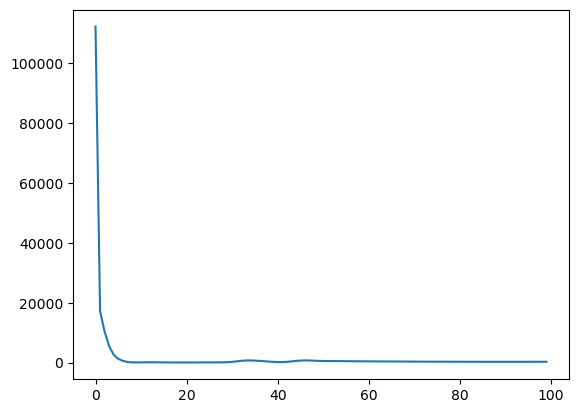

In [16]:
Gamma0 = np.ones((d_1,d_2))
S0 = np.ones((d_1,d_2))
tfinal = 100

#Cálculo de L:
aux = []
for i in range(n):
    xi = np.asarray(X[i])
    aux.append(xi @ xi.T)
L = 4*np.max(la.eigvalsh(sum(aux)/n))

lambd = sd*np.sqrt((d_1+d_2)/n)
a = Gamma_mag/np.sqrt(n)
tau = sd*np.sqrt(np.log(d_1*d_2)/n) + Gamma_mag/np.sqrt(n)

f2 = trace_reg_MD_acc(df, n,d_1,d_2,X,y,L,lambd,tau,a,Gamma0,S0,tfinal)
plt.plot(f2[0])

# Exercício 9: 

Implemente num mesmo gráfico os erros $k\mapsto\Vert\nabla f(\Gamma_k,S_k)\Vert_F^2$ de cada método em função no número de iterações.

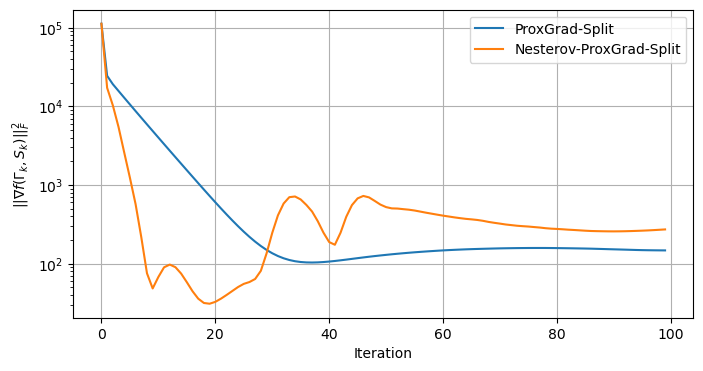

In [17]:
#Escreva o código aqui
plt.figure(figsize=(8, 4))
plt.plot(f1[0], label='ProxGrad-Split')
plt.plot(f2[0], label='Nesterov-ProxGrad-Split')
plt.yscale('log')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('$||\\nabla f (\\Gamma_k , S_k)||^2_F$')
plt.legend()
plt.show()

# PCA robusta

O modelo anterior é *supervisionado*. Em *visão computacional*, um modelo relacionando mas não-supervisionado consiste em estimar cada uma das componentes $[\Gamma^*,S^*]$ tendo apenas uma medição ruidosa da soma $B^*=\Gamma^*+S^*$, por exemplo, ao separar de uma foto um carro (image esparsa) do ambiente (imagem de posto pequeno):

![](Robust-PCA.png)

Neste caso, resolvemos:

\begin{equation*}
\begin{aligned}
& \underset{[\Gamma,S]\in(\mathbb{R}^{d_1\times d_2})^2}{\text{minimize}}
& & F(\Gamma,S) + \lambda\Vert \Gamma\Vert_N + \tau\Vert S\Vert_1, \\
& \text{sujeito à}
& & \Vert\Gamma\Vert_\infty\le a, 
\end{aligned}
\end{equation*}

onde 

$$
F(\Gamma,S) = \frac{1}{2}\Vert Y - (\Gamma+S)\Vert_F^2, 
$$

$Y$ é uma matriz de dados em $\mathbb{R}\times\mathbb{R}^{d_1\times d_2}$, por exemplo, uma imagem ruidosa. Aplicações incluem *vigilância por vídeos*, *reconhecimento facial*, *topic modelling* (incluindo *latent semantic analysis* e *sentiment analysis*) e *recomendação de sistemas* sujeito a dados corruptos. Veja e.g. [Robust PCA?](https://arxiv.org/abs/0912.3599) e [Video](https://www.youtube.com/watch?v=yDpz0PqULXQ).

# Exercício 10:

Construa uma função ``data_genYe(n,d_1,d_2,B_true,sd)`` que toma $n$, $d_1$, $d_2$, $B^*$, e um número positivo ``sd`` e constrói a matriz de dados ``Y`` tal que

$$
Y = B^* + \text{sd}\cdot\Xi,
$$

onde $\Xi$ é uma matriz $d_1\times d_2$ cujas entradas são iid $N(0,1)$. NOTA: Iremos usar as mesmas funções anteriores para gerar $\Gamma^*$ e $S^*$.

In [18]:
#Escreva o código aqui
def data_genYe(n, d1, d2, B_true, sd):
    Xi = np.random.randn(d1, d2)
    
    Y = B_true + sd * Xi
    
    return Y

In [19]:
#Exemplo:
d_1=40
d_2=40
r=5
s=10
Gamma_mag=10
S_mag=10
sd = .1
n = 100

Gamma_true = data_genG(n,d_1,d_2,r,Gamma_mag)
S_true = data_genS(d_1,d_2,s,S_mag)
B_true = Gamma_true + S_true
Y = data_genYe(n,d_1,d_2,B_true,sd)

In [20]:
Y.shape, Y

((40, 40),
 array([[ 1.23602458e-01, -1.36958459e-01,  6.42550915e-02, ...,
          9.87027297e+00,  1.20562770e-01, -3.28919446e-01],
        [ 2.93998936e-01, -9.02827851e-02, -2.66685897e-01, ...,
         -1.61153007e-01,  5.95700745e-03, -2.61329551e-01],
        [-5.08857280e-02, -4.36491522e-01,  1.23451779e-01, ...,
          2.63481217e-01, -2.05965044e-02,  2.24665453e-01],
        ...,
        [ 2.12835277e-01, -2.12776655e-01, -2.82941837e-01, ...,
          5.96210083e-02, -6.15335886e-02, -1.23201440e-01],
        [-7.84962591e-02, -1.73571622e-01,  1.01847509e-02, ...,
          2.55578773e-02,  7.75016499e-02,  3.07110381e-01],
        [ 1.06426550e-01, -8.12989938e-02,  7.02836829e-02, ...,
         -9.43443899e-03,  6.36544254e-02,  1.65005558e-01]]))

# Exercício 11:

Construa uma função `dF(Gamma,S)` que retorna o gradiente $\nabla F(\Gamma,S)$.

In [21]:
#Escreva o código aqui
def dF(Gamma, S, Y):
    error = Y - (Gamma + S)
    
    dF_Gamma = -error
    dF_S = -error
    
    return dF_Gamma, dF_S

# Exercício 12: 

Vamos usar o método gradiente proximal com splitting para resolver o problema àcima. Ele tem exatamente a mesma expressão do Exercício 6 mas usando $\nabla F(\Gamma,S)$. Implemente o algoritmo com

\begin{align*}
a &= \frac{\Gamma_{mag}}{\sqrt{n}},\\
\lambda &= \text{sd}\sqrt{\frac{d_1+d_2}{n}},\\
\tau &= \text{sd}\sqrt{\frac{\log(d_1d_2)}{n}} + \frac{\Gamma_{mag}}{\sqrt{n}}.
\end{align*}

e passo $1/L$. PERGUNTA: Exiba um limite aproximado em que para $L$ os métodos convergem e para um $L$ próximo os métodos não convergem. 

Em seguida, implemente o método gradiente proximal com splitting acelerado: é o mesmo que o exercício 8 mas usando $\nabla F(\Gamma,S)$.

Finalmente, plote num mesmo gráfico a sequência de erros $\Vert\nabla f(\Gamma_k,S_k)\Vert_F^2$ para os dois métodos.

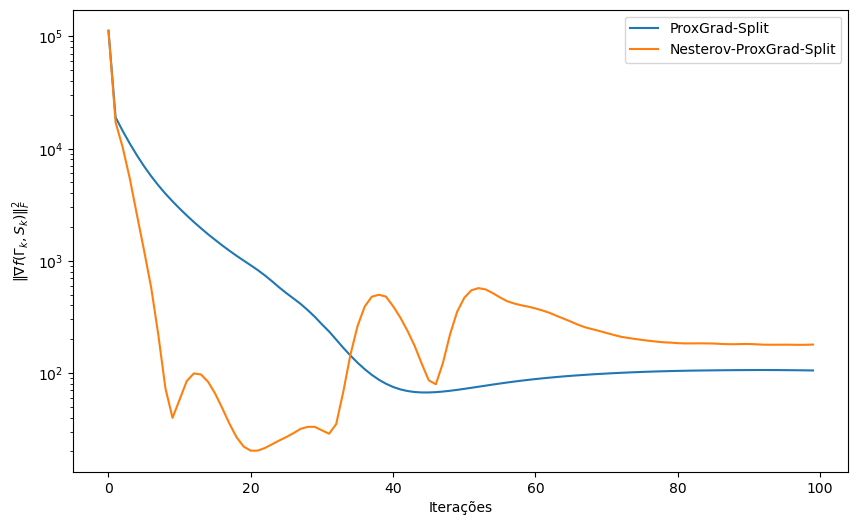

In [22]:
#Escreva o código aqui
a = Gamma_mag / np.sqrt(n)
lambd = sd * np.sqrt((d_1 + d_2) / n)
tau = sd * np.sqrt(np.log(d_1 * d_2) / n) + Gamma_mag / np.sqrt(n)

Gamma_init = np.random.randn(d_1, d_2)
S_init = np.random.randn(d_1, d_2)
Y = np.random.randn(d_1, d_2)

f1 = trace_reg_MD(df, n,d_1,d_2,X,y,L,lambd,tau,a,Gamma0,S0,tfinal)
f2 = trace_reg_MD_acc(df, n,d_1,d_2,X,y,L,lambd,tau,a,Gamma0,S0,tfinal)

plt.figure(figsize=(10, 6))
plt.plot(f1[0], label='ProxGrad-Split')
plt.plot(f2[0], label='Nesterov-ProxGrad-Split')
plt.yscale("log")
plt.xlabel("Iterações")
plt.ylabel(r"$\Vert \nabla f(\Gamma_k, S_k) \Vert_F^2$")
plt.legend()
plt.show()